In [13]:
from preprocessing import load_folder_paths, load_dcm_datasets

paths = load_folder_paths()

ds = load_dcm_datasets(paths[0])
ds[0].PixelSpacing, ds[0].SliceThickness

Dicom files loaded, count: 288


([0.488281, 0.488281], '5.0')

In [18]:
from preprocessing import get_volume
from scipy import ndimage
import matplotlib.pyplot as plt
v = get_volume(paths[13], extract_brain=False, windowing=True, correct_motion=False, spatial_downsampling_factor=2, temporal_downsampling_factor=7)
v1 = v[0]
v2 = v[1]
v_smoothed = ndimage.gaussian_filter(v1, sigma=1.0)

Loading /Users/simonma/Desktop/UniToBrain/MOL-100...
Dicom files loaded, count: 288
Processing /Users/simonma/Desktop/UniToBrain/MOL-100...
5 [0.488281, 0.488281]


ic| window_center: 40, window_width: 80
ic| volume_seq.max(): 80.0
    volume_seq.min(): 0.0
    volume_seq.dtype: dtype('float32')


Done!


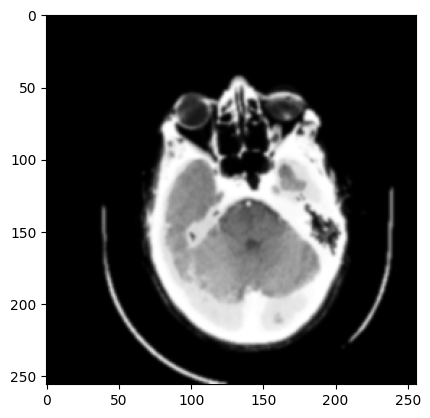

In [19]:
plt.imshow(v_smoothed[0], cmap='gray')
plt.show()


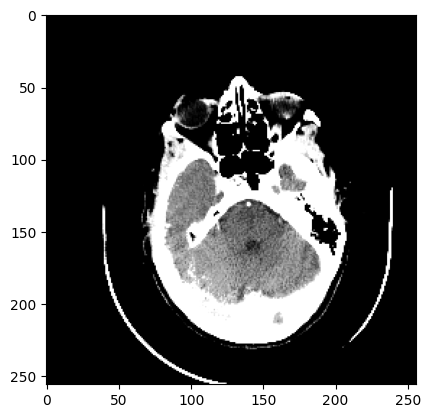

In [21]:
plt.imshow(v1[0], cmap='gray')

In [60]:

import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

def interactive_registration(fixed_image: np.ndarray, 
                           moving_image: np.ndarray,
                           max_iterations: int = 500,
                           lr=1.0,
                           smoothen=False) -> np.ndarray:
    """
    Performs rigid registration between two 2D images with interactive visualization.
    Shows moving image overlaid on fixed image in real-time during registration.
    
    Parameters:
    - fixed_image: Reference image (2D numpy array)
    - moving_image: Image to be registered (2D numpy array) 
    - max_iterations: Maximum number of iterations for optimization
    
    Returns:
    - Registered moving image
    """
    # Convert numpy arrays to SITK images
    fixed = sitk.GetImageFromArray(fixed_image)
    moving = sitk.GetImageFromArray(moving_image)
    
    if smoothen:
        fixed = sitk.SmoothingRecursiveGaussian(fixed, 2.0)
        moving_original = sitk.Image(moving)
        moving = sitk.SmoothingRecursiveGaussian(moving, 2.0)
    
    # Initialize transform
    initial_transform = sitk.CenteredTransformInitializer(
        fixed, moving,
        sitk.Euler2DTransform(),
        sitk.CenteredTransformInitializerFilter.GEOMETRY
    )
    
    # Setup registration method
    registration_method = sitk.ImageRegistrationMethod()
    registration_method.SetMetricAsMeanSquares()
    registration_method.SetOptimizerAsRegularStepGradientDescent(
        learningRate=lr,
        minStep=1e-4,
        numberOfIterations=max_iterations,
        gradientMagnitudeTolerance=1e-8
    )
    registration_method.SetInitialTransform(initial_transform)
    registration_method.SetInterpolator(sitk.sitkLinear)
    
    # Create figure once
    plt.figure(figsize=(8, 8))
    
    # Setup interactive plotting
    def plot_overlay(fixed_img, moving_img, iteration):
        clear_output(wait=True)
        
        plt.clf()  # Clear current figure
        plt.imshow(fixed_img, cmap='gray')
        plt.imshow(moving_img, cmap='hot', alpha=0.5)
        plt.title(f'Registration Progress - Iteration {iteration}')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    
    # Add observer to visualize registration progress
    def command_iteration(method):
        if (method.GetOptimizerIteration() + 1) % 50 == 0:
            # Get current transform and apply to moving image
            transform = method.GetInitialTransform()
            transformed = sitk.Resample(
                moving, fixed,
                transform,
                sitk.sitkLinear,
                0.0,
                moving.GetPixelID()
            )
            
            # Convert to numpy and plot
            current_moving = sitk.GetArrayFromImage(transformed)
            plot_overlay(fixed_image, current_moving, method.GetOptimizerIteration())
            
            print(f"Iteration: {method.GetOptimizerIteration()}")
            print(f"Metric value: {method.GetMetricValue():.4f}")
    
    registration_method.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(registration_method))
    
    # Execute registration
    final_transform: sitk.Euler2DTransform = registration_method.Execute(fixed, moving)
    print(f"Final metric value: {registration_method.GetMetricValue():.4f}")
    print(f"Final transform: {final_transform.GetTranslation()}")
    # Apply final transform
    if smoothen:    
        final_moving = sitk.Resample(
            moving_original, fixed,
            final_transform,
            sitk.sitkLinear,
            0.0,
            moving_original.GetPixelID()
        )
    else:
        final_moving = sitk.Resample(
            moving, fixed,
            final_transform,
            sitk.sitkLinear,
            0.0,
            moving.GetPixelID()
        )
    return sitk.GetArrayFromImage(final_moving)


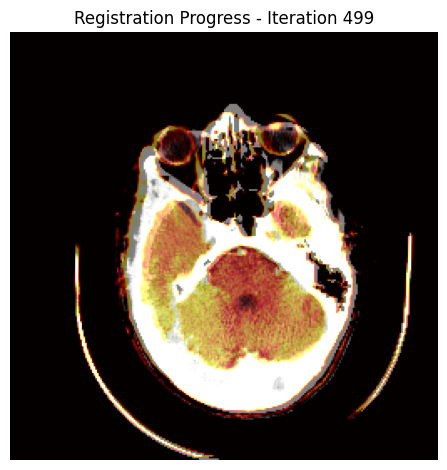

Iteration: 499
Metric value: 301.9701
Final metric value: 301.9701
Final transform: (-0.3789943669447779, 1.9331899646056716)


In [69]:
# Test the function with two slices
fixed_slice = v1[0]
moving_slice = v2[0]
registered = interactive_registration(fixed_slice, moving_slice, lr=5)

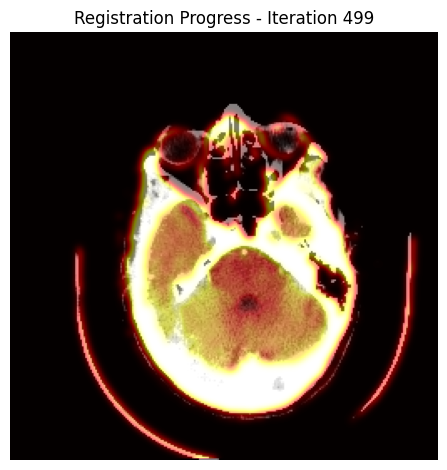

Iteration: 499
Metric value: 59.3744
Final metric value: 59.3744
Final transform: (-1.8602101294338302, 0.6197702245356799)


In [70]:
registered = interactive_registration(fixed_slice, moving_slice, lr=1, smoothen=True, max_iterations=500)


In [23]:
def experiment_registration_params(fixed_slice, moving_slice, 
                                 learning_rates=[0.1, 0.5, 1.0, 2.0, 5.0],
                                 num_iterations=[100, 200, 500, 1000, 2000]):
    """
    Experiment with different registration parameters and compare results.
    
    Parameters:
    - fixed_slice: Reference image to register to
    - moving_slice: Image to be registered
    - learning_rates: List of learning rates to try
    - num_iterations: List of max iteration counts to try  
    - min_steps: List of minimum step sizes to try
    
    Returns:
    - Dictionary containing best parameters and their metric value
    """
    best_metric = float('inf')
    best_params = {}
    results = []
    
    for lr in learning_rates:
        for iters in num_iterations:
            # Set up registration method
            registration_method = sitk.ImageRegistrationMethod()
            registration_method.SetMetricAsMeanSquares()
            registration_method.SetOptimizerAsRegularStepGradientDescent(
                learningRate=lr,
                minStep=1e-4,
                numberOfIterations=iters,
                gradientMagnitudeTolerance=1e-8
            )
            
            # Convert slices to SimpleITK images
            fixed = sitk.GetImageFromArray(fixed_slice)
            moving = sitk.GetImageFromArray(moving_slice)
            
            # Initialize transform
            initial_transform = sitk.CenteredTransformInitializer(
                fixed, moving,
                sitk.AffineTransform(2),
                sitk.CenteredTransformInitializerFilter.GEOMETRY
            )
            registration_method.SetInitialTransform(initial_transform)
            registration_method.SetInterpolator(sitk.sitkLinear)
            
            try:
                # Execute registration
                final_transform = registration_method.Execute(fixed, moving)
                final_metric = registration_method.GetMetricValue()
                
                results.append({
                    'learning_rate': lr,
                    'iterations': iters, 
                    'metric': final_metric
                })
                
                if final_metric < best_metric:
                    best_metric = final_metric
                    best_params = {
                        'learning_rate': lr,
                        'iterations': iters,
                        'metric': final_metric
                    }
                    
                # print(f"LR: {lr}, Iterations: {iters}")
                # print(f"Final metric value: {final_metric:.4f}")
                
            except RuntimeError as e:
                print(f"Registration failed with params LR={lr}, Iter={iters}")
                print(f"Error: {e}")
                    
    print("\nBest parameters found:")
    print(f"Learning rate: {best_params['learning_rate']}")
    print(f"Iterations: {best_params['iterations']}")
    print(f"Metric value: {best_params['metric']:.4f}")
    
    return best_params, results


In [28]:
best_params, results = experiment_registration_params(fixed_slice, moving_slice)


LR: 0.1, Iterations: 100
Final metric value: 284.6103
LR: 0.1, Iterations: 200
Final metric value: 276.6870
LR: 0.1, Iterations: 500
Final metric value: 268.8325
LR: 0.1, Iterations: 1000
Final metric value: 250.1276
LR: 0.1, Iterations: 2000
Final metric value: 232.7704
LR: 0.5, Iterations: 100
Final metric value: 285.5878
LR: 0.5, Iterations: 200
Final metric value: 274.0109
LR: 0.5, Iterations: 500
Final metric value: 270.8792
LR: 0.5, Iterations: 1000
Final metric value: 261.5541
LR: 0.5, Iterations: 2000
Final metric value: 238.0638
LR: 1.0, Iterations: 100
Final metric value: 283.7586
LR: 1.0, Iterations: 200
Final metric value: 271.0118
LR: 1.0, Iterations: 500
Final metric value: 271.4733
LR: 1.0, Iterations: 1000
Final metric value: 260.0296
LR: 1.0, Iterations: 2000
Final metric value: 237.6284
LR: 2.0, Iterations: 100
Final metric value: 1214.8738
LR: 2.0, Iterations: 200
Final metric value: 1150.9554
LR: 2.0, Iterations: 500
Final metric value: 1022.4025
LR: 2.0, Iterations

In [29]:
best_params

{'learning_rate': 5.0, 'iterations': 2000, 'metric': 226.82716705002866}

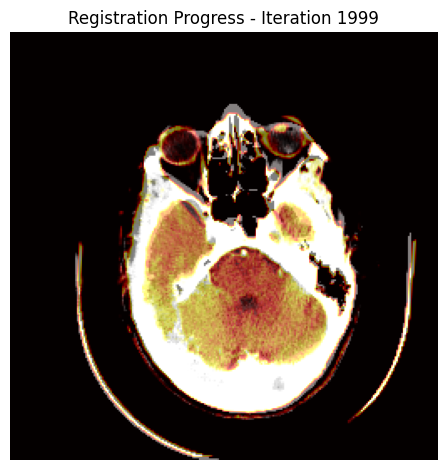

Iteration: 1999
Metric value: 226.5981
Final metric value: 226.5981
Final transform: (-2.5067021169850197, 1.4679581904347363)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [24]:
interactive_registration(fixed_slice, moving_slice,  2000, 10)

Loading /Users/simonma/Desktop/UniToBrain/MOL-100...
Dicom files loaded, count: 288
Processing /Users/simonma/Desktop/UniToBrain/MOL-100...
5 [0.488281, 0.488281]


ic| label_count: array([892871,    800,    513,    504,     68, 153778,      1,      1,
                            38,      1,      1])
ic| label_count: array([895173,    595,    138,    415,     17, 152183,      1,     53,
                             1])


Done!
Info: Downsampling detected (2x), adjusting morphology_shape_2d from (1, 3) to (1, 2)
Info: Downsampling detected (2x), adjusting remove_small_objects_size from 500 to 125
get_3d_mask took 0.10497736930847168 seconds
Info: Downsampling detected (2x), adjusting morphology_shape_2d from (1, 3) to (1, 2)
Info: Downsampling detected (2x), adjusting remove_small_objects_size from 500 to 125
get_3d_mask took 0.09968018531799316 seconds


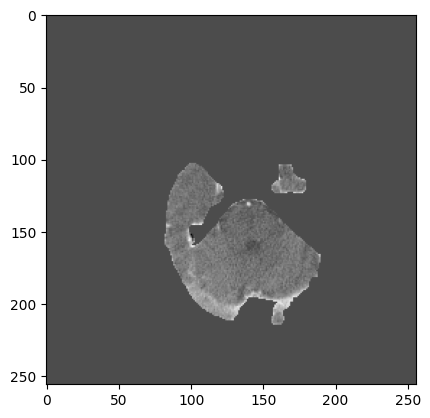

In [43]:
from preprocessing import get_3d_mask
be_v = get_volume(paths[13], extract_brain=False, windowing=False, correct_motion=False, filter=False, spatial_downsampling_factor=2, temporal_downsampling_factor=7)
be_v1 = be_v[0] * get_3d_mask(be_v[0])
be_v2 = be_v[1] * get_3d_mask(be_v[1])
plt.imshow(be_v1[0], cmap='gray')





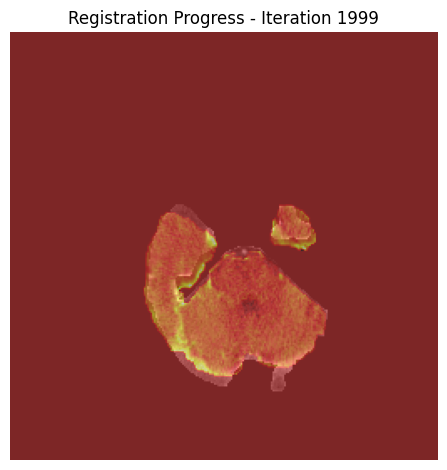

Iteration: 1999
Metric value: 157.9043
Final metric value: 157.9043
Final transform: (-2.6914425421911625, -0.6917669278530064)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [45]:
interactive_registration(be_v1[0], be_v2[0], lr=5, max_iterations=2000)

In [135]:
def register_volume(moving_volume: np.ndarray, reference_volume: np.ndarray, lr: float = 0.1, n_iters: int = 500, spacing: np.ndarray = (5.0, 0.488281, 0.488281)) -> np.ndarray:
    """
    Registers a single volume to the reference image using rigid registration.
    Uses smoothed volumes for registration but applies transformation to original volume.
    """
    # Convert to SimpleITK images and set physical spacing
    moving_image = sitk.GetImageFromArray(moving_volume)
    moving_image.SetSpacing(spacing)
    reference_image = sitk.GetImageFromArray(reference_volume)
    reference_image.SetSpacing(spacing)
    
    # # Create smoothed versions for registration
    smoothed_target = ndimage.gaussian_filter(moving_volume, sigma=(1.0, 1.0), axes=(1, 2))
    smoothed_reference = ndimage.gaussian_filter(reference_volume, sigma=(1.0, 1.0), axes=(1, 2))
    
    mod_moving = sitk.GetImageFromArray(smoothed_target)
    mod_reference = sitk.GetImageFromArray(smoothed_reference)
    mod_moving.SetSpacing(spacing)
    mod_reference.SetSpacing(spacing)
    
    # Initialize the transform with center of rotation at image center
    initial_transform = sitk.CenteredTransformInitializer(
        mod_reference, 
        mod_moving,
        sitk.Euler3DTransform(),
        sitk.CenteredTransformInitializerFilter.MOMENTS
    )
    print(initial_transform)
    registration_method = sitk.ImageRegistrationMethod()
    registration_method.SetMetricAsMeanSquares()
    registration_method.SetOptimizerAsRegularStepGradientDescent(
        learningRate=lr,
        minStep=1e-4,
        numberOfIterations=n_iters,
        gradientMagnitudeTolerance=1e-8
    )
    registration_method.SetInitialTransform(initial_transform)
    registration_method.SetInterpolator(sitk.sitkLinear)
    
        # Create figure once
    plt.figure(figsize=(8, 8))
    
    # Setup interactive plotting
    def plot_overlay(fixed_img, moving_img, iteration):
        clear_output(wait=True)
        
        plt.clf()  # Clear current figure
        plt.imshow(fixed_img, cmap='gray')
        plt.imshow(moving_img, cmap='hot', alpha=0.5)
        plt.title(f'Registration Progress - Iteration {iteration}')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
    # Add optimizer observer to prevent large transformations
    def command_iteration(method):
        it = method.GetOptimizerIteration()
        if it == 0:
            print(f"Starting registration...")
        # if (it + 1) % 50 == 0:
        #     print(f"{method.GetOptimizerIteration()}: {method.GetMetricValue()}")
        #     # Get current transform parameters
        #     transform = method.GetOptimizerPosition()
        #     # Check for unreasonable transformations (e.g., large rotations)
        transform = method.GetOptimizerPosition()
        if any(abs(angle) > np.pi/6 for angle in transform.GetRotation()):
            print("Warning: Excessive rotation detected - stopping optimization")
            method.StopOptimization()

        # Get current transform and apply it to moving volume
        # current_transform = method.GetInitialTransform()
        # transformed = sitk.Resample(
        #     moving_image, reference_image,
        #     current_transform,
        #     sitk.sitkLinear,
        #     0.0,
        #     moving_image.GetPixelID()
        # )
        # # Convert to numpy and plot
        # fixed_image = reference_volume[0]
        # current_moving = sitk.GetArrayFromImage(transformed)[0]
        # plot_overlay(fixed_image, current_moving, it)
                
    registration_method.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(registration_method))

    # Execute the registration using smoothed skull masks
    try:
        final_transform = registration_method.Execute(mod_reference, mod_moving)
    except RuntimeError as e:
        print(f"Registration failed: {e}")
        return moving_volume  # Return original volume if registration fails
    
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(reference_image)
    resampler.SetTransform(final_transform)
    resampler.SetInterpolator(sitk.sitkLinear)
    # resampler.SetDefaultPixelValue(-1024)  # Standard air HU value
    
    try:
        registered_image = resampler.Execute(moving_volume)
        registered_volume = sitk.GetArrayFromImage(registered_image)
        
        # Verify the registration result
        if np.sum(registered_volume > -1000) < 0.5 * np.sum(moving_volume > -1000):
            print("Warning: Registration may have failed (large portion of volume missing)")
            return moving_volume
            
        print(f"Volume registered with final metric value: {registration_method.GetMetricValue()}")
        return registered_volume#, registration_method.GetMetricValue()
    except RuntimeError as e:
        print(f"Resampling failed: {e}")
        return moving_volume

In [137]:
import SimpleITK as sitk
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
from IPython.display import clear_output

def plot_overlay(fixed_img, moving_img, iteration):
    """
    Plot overlay of fixed and moving images for registration visualization.
    
    Parameters:
    -----------
    fixed_img : np.ndarray
        2D slice from fixed image
    moving_img : np.ndarray
        2D slice from moving image
    iteration : int
        Current iteration number
    """
    clear_output(wait=True)
    
    plt.clf()  # Clear current figure
    plt.imshow(fixed_img, cmap='gray')
    plt.imshow(moving_img, cmap='hot', alpha=0.5)
    plt.title(f'Registration Progress - Iteration {iteration}')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def register_volume(moving_volume: np.ndarray, reference_volume: np.ndarray, lr: float = 0.1, n_iters: int = 500, spacing: np.ndarray = (5.0, 0.488281, 0.488281)) -> np.ndarray:
    """
    Registers a single volume to the reference image using rigid registration.
    Uses smoothed volumes for registration but applies transformation to original volume.
    """
    # Print input shapes for debugging
    print(f"Input shapes - Moving: {moving_volume.shape}, Reference: {reference_volume.shape}")
    
    # Create figure once
    plt.figure(figsize=(8, 8))
    
    # Convert to SimpleITK images and set physical spacing
    # Explicitly handle axis ordering
    moving_image = sitk.GetImageFromArray(moving_volume.transpose(2, 1, 0))  # Convert to (x,y,z)
    reference_image = sitk.GetImageFromArray(reference_volume.transpose(2, 1, 0))
    
    moving_image.SetSpacing(spacing)
    reference_image.SetSpacing(spacing)
    
    # Create smoothed versions for registration
    smoothed_target = ndimage.gaussian_filter(moving_volume, sigma=(1.0, 1.0), axes=(1, 2))
    smoothed_reference = ndimage.gaussian_filter(reference_volume, sigma=(1.0, 1.0), axes=(1, 2))
    
    mod_moving = sitk.GetImageFromArray(smoothed_target.transpose(2, 1, 0))
    mod_reference = sitk.GetImageFromArray(smoothed_reference.transpose(2, 1, 0))
    mod_moving.SetSpacing(spacing)
    mod_reference.SetSpacing(spacing)
    
    # Set direction to identity to ensure consistent orientation
    identity_direction = [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]
    mod_moving.SetDirection(identity_direction)
    mod_reference.SetDirection(identity_direction)
    moving_image.SetDirection(identity_direction)
    reference_image.SetDirection(identity_direction)
    
    # Initialize transform with identity rotation
    initial_transform = sitk.Euler3DTransform()
    image_center = reference_image.TransformContinuousIndexToPhysicalPoint([
        index/2.0 for index in reference_image.GetSize()
    ])
    initial_transform.SetCenter(image_center)
    initial_transform.SetRotation(0.0, 0.0, 0.0)  # Start with no rotation
    
    # Print initial transform parameters for debugging
    print("Initial transform parameters:")
    print(f"Center: {initial_transform.GetCenter()}")
    print(f"Rotation: {np.degrees(initial_transform.GetVersor())}")
    print(f"Translation: {initial_transform.GetTranslation()}")
    
    registration_method = sitk.ImageRegistrationMethod()
    registration_method.SetMetricAsMeanSquares()
    registration_method.SetOptimizerAsRegularStepGradientDescent(
        learningRate=lr,
        minStep=1e-4,
        numberOfIterations=n_iters,
        gradientMagnitudeTolerance=1e-8
    )
    registration_method.SetInitialTransform(initial_transform)
    registration_method.SetInterpolator(sitk.sitkLinear)
    
    # Modify the command_iteration function to print transform parameters
    def command_iteration(method):
        it = method.GetOptimizerIteration()
        if it == 0:
            print(f"Starting registration...")
        if (it + 1) % 10 == 0:
            current_transform = method.GetCurrentTransform()
            angles = [np.degrees(angle) for angle in current_transform.GetVersor()]
            print(f"Iteration {it + 1}:")
            print(f"  Metric value: {method.GetMetricValue():.6f}")
            print(f"  Angles (degrees): {angles}")
            print(f"  Translation: {current_transform.GetTranslation()}")
            
            # Check for unreasonable transformations
            if any(abs(angle) > 45 for angle in angles):  # limit to 45 degrees
                print("Warning: Large rotation detected")
                method.StopOptimization()
            
            if hasattr(method, 'GetOptimizerPosition'):
                print(f"  Optimizer position: {method.GetOptimizerPosition()}")
                
            # Update visualization if needed
            transformed = sitk.Resample(
                moving_image, reference_image,
                current_transform,
                sitk.sitkLinear,
                0.0,
                moving_image.GetPixelID()
            )
            # Get middle slices for visualization
            fixed_slice = reference_volume[reference_volume.shape[0]//2]
            moving_array = sitk.GetArrayFromImage(transformed)
            moving_slice = moving_array[moving_array.shape[0]//2]
            plot_overlay(fixed_slice, moving_slice, it)
                
    registration_method.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(registration_method))

    try:
        final_transform = registration_method.Execute(mod_reference, mod_moving)
        
        # Print final transform parameters
        print("\nFinal transform parameters:")
        print(f"Rotation (degrees): {np.degrees(final_transform.GetVersor())}")
        print(f"Translation: {final_transform.GetTranslation()}")
        
    except RuntimeError as e:
        print(f"Registration failed: {e}")
        return moving_volume
    
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(reference_image)
    resampler.SetTransform(final_transform)
    resampler.SetInterpolator(sitk.sitkLinear)
    
    try:
        registered_image = resampler.Execute(moving_image)
        # Convert back to original axis ordering
        registered_volume = sitk.GetArrayFromImage(registered_image).transpose(2, 1, 0)
        
        # Verify the registration result
        if np.sum(registered_volume > -1000) < 0.5 * np.sum(moving_volume > -1000):
            print("Warning: Registration may have failed (large portion of volume missing)")
            return moving_volume
            
        print(f"Volume registered with final metric value: {registration_method.GetMetricValue()}")
        return registered_volume
        
    except RuntimeError as e:
        print(f"Resampling failed: {e}")
        return moving_volume

In [138]:
reg_v = register_volume(v1, v2, lr=1, n_iters=2000)

Input shapes - Moving: (16, 256, 256), Reference: (16, 256, 256)
Initial transform parameters:
Center: (40.0, 62.499968, 62.499968)


AttributeError: 'Euler3DTransform' object has no attribute 'GetVersor'

<Figure size 800x800 with 0 Axes>

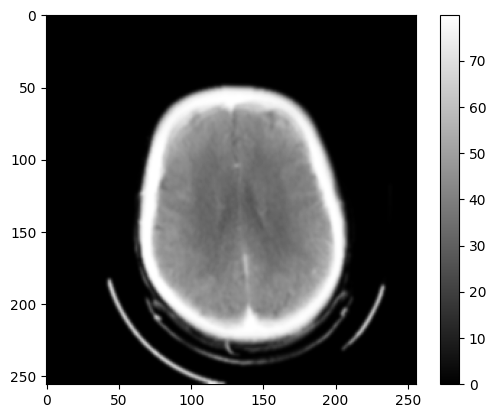

In [91]:
plt.imshow(reg_v[10], cmap='gray')
plt.colorbar()
plt.show()

In [117]:
a = np.reshape(np.arange(24), (2, 3, 4))
a

array([[[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]],

       [[12, 13, 14, 15],
        [16, 17, 18, 19],
        [20, 21, 22, 23]]])

In [118]:
np.sum(a, axis=0)

array([[12, 14, 16, 18],
       [20, 22, 24, 26],
       [28, 30, 32, 34]])

In [119]:
np.sum(a, axis=1)

array([[12, 15, 18, 21],
       [48, 51, 54, 57]])

In [120]:
np.sum(a, axis=2)

array([[ 6, 22, 38],
       [54, 70, 86]])